# Prediction computation and evaluation

Once the neural network has been trained, one can use the fitted weights to infer a prediction of an image that the model has never seen. In this stage we can test the predictive power of the network by comparing the inferred results with previously labelled data. In this notebook we will load define a variable containing the model where we can load the trained weight and subsequently use our test data to evaluate our model, once this is done we store the results in an array so we can plot which image has the best prediction and compare it with the worst prediction. To define which is the most/least accurate prediction we'll have to use some metrics, here we'll use the dice metric. Furthermore, before doing any inference we will check how the training went so that we may have an idea on the final performance on the test set.

In [1]:
# import the modules and clear any previous keras session to avoid possible errors

import numpy as np
import tensorflow as tf
import os
from glob import glob
import tensorflow.keras.backend as K
from PIL import Image
import json
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import Data_Generator.DataGenerator as DG
import Loss_Metrics.LossMetrics 
import UNet_Arch.UNET_architecture as unet

K.clear_session()

## Evaluate the training

To do this we'll read the history.json file and extract the information to be plotted.

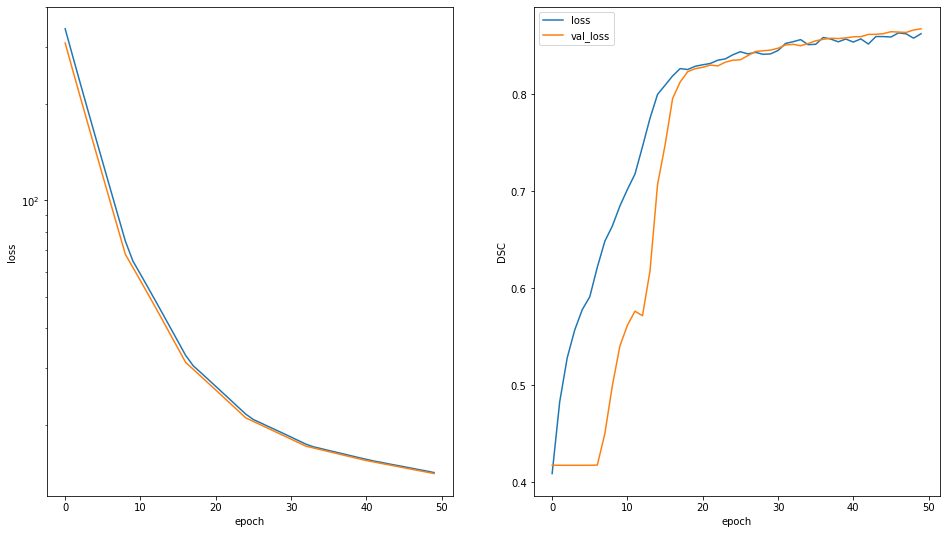

In [2]:
history_dict = json.load(open("history.json", 'r'))
history_dict = json.loads(r"{}".format(history_dict).replace("\"","").replace("'","\""))

fig, ax = plt.subplots(1,2,figsize=(16,9))
epochs = range(len(history_dict["loss"]))
ax[0].plot(epochs, history_dict["loss"], label="loss")
ax[0].plot(epochs, history_dict["val_loss"], label="val_loss")
ax[1].plot(epochs, history_dict["DSC"], label="loss")
ax[1].plot(epochs, history_dict["val_DSC"], label="val_loss")

ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[1].set_ylabel("DSC")

ax[0].set_yscale("log")

plt.legend()
plt.show()
plt.close()

At this point you may notice two things, that the training has gone in overfitting if validation and training metrics separate at the last epoch or that it has not gone into overfitting if the metrics follow the same trend. If the validation metric has a reasonable value, one can go forward and try to infer results on the test data.

## Import the test data

First of all we'll import the data against which we'll evaluate the network inference. 

NB: the size of the image should be defined correctly and also the indexes of the images

In [3]:
dim = 128

path='./Shezen_{:d}{:d}/'.format(dim,dim) # input images path

data_path=os.path.join(path,"*")#'../../shared/postuma/Shezen_{:d}{:d}/*'.format(dim,dim)
data_list = [os.path.basename(f) for f in glob(data_path)] 

test_list = data_list[590:]

print(test_list)
model = unet.U_net((dim,dim,1))
# NB: load your weights file
#model.load_weights(best_w[-1])
model.load_weights('../results/weights-val-050-14.17-0.87.hdf5')

['CHNCXR_0459_1_mask.npy', 'MCUCXR_0063_0.npy', 'CHNCXR_0635_1_mask.npy', 'MCUCXR_0350_1.npy', 'CHNCXR_0153_0_mask.npy', 'CHNCXR_0273_0_mask.npy', 'CHNCXR_0112_0_mask.npy', 'CHNCXR_0619_1_mask.npy', 'MCUCXR_0194_1.npy', 'CHNCXR_0165_0_mask.npy', 'CHNCXR_0397_1_mask.npy', 'CHNCXR_0102_0_mask.npy', 'CHNCXR_0249_0_mask.npy', 'CHNCXR_0395_1_mask.npy', 'CHNCXR_0599_1_mask.npy', 'CHNCXR_0516_1_mask.npy', 'CHNCXR_0575_1_mask.npy', 'CHNCXR_0537_1_mask.npy', 'CHNCXR_0574_1_mask.npy', 'CHNCXR_0509_1_mask.npy', 'CHNCXR_0144_0_mask.npy', 'CHNCXR_0523_1_mask.npy', 'CHNCXR_0633_1_mask.npy', 'MCUCXR_0089_0.npy', 'CHNCXR_0470_1_mask.npy', 'CHNCXR_0330_1_mask.npy', 'CHNCXR_0462_1_mask.npy', 'CHNCXR_0373_1_mask.npy', 'MCUCXR_0113_1.npy', 'CHNCXR_0133_0_mask.npy', 'CHNCXR_0370_1_mask.npy', 'CHNCXR_0141_0_mask.npy', 'CHNCXR_0572_1_mask.npy', 'CHNCXR_0156_0_mask.npy', 'CHNCXR_0513_1_mask.npy', 'CHNCXR_0598_1_mask.npy', 'CHNCXR_0444_1_mask.npy', 'CHNCXR_0394_1_mask.npy', 'CHNCXR_0567_1_mask.npy', 'CHNCXR_05

## Prediction

Here we'll perform the prediction and store the results.

NB: the loaded numpy array has the following dimension (x,y,c), where x and y are the size of the image while c the number of channels. The keras ```predict``` method reads multiple images at once, in this example we'll iterate through the images and infer the results one image at a time. So in this case we should pass to ```predict```and image with shape (1,x,y,c).

In [11]:
dice = []
bdsc = []
pred = []

for patient in test_list:
    print(patient)
    data = np.load(path + patient)
    img = np.expand_dims(data[:,:,0], axis=-1)
    img = np.expand_dims(img, axis=0)

    print(img.shape)
    label = data[:,:,1]
    label = np.expand_dims(data[:,:,1], axis=-1)
    label = np.expand_dims(label, axis=0)


    prediction = model.predict(img)
    prediction = np.round(prediction)
    print(prediction.shape)
    pred.append(prediction)
    dice.append(Loss_Metrics.LossMetrics.DSC(label.astype('float32'), prediction.astype('float32')))
    bdsc.append(Loss_Metrics.LossMetrics.border_dice(label[0,:,:,0],prediction[0,:,:,0]))
    
    #img_label = Image.fromarray((prediction[0,:,:,0]*255)).convert('L')
    #img = Image.fromarray((img[0,:,:,0]*255)).convert('L')

    #img.paste(img_label, (0,0), mask = img_label)
    #img_name = '../prediction_png/' + patient[:-4] +'.png'
    #img.save(img_name)


avg_dice = np.mean(dice)
std_dice = np.std(dice)
avg_sdsc = np.mean(bdsc)
std_sdsc = np.std(bdsc)

print('***************************************+')
print('Mean DSC', avg_dice, '+-', std_dice)
print('Mean BDSC', avg_sdsc, '+-', std_sdsc)
print('***************************************+')


CHNCXR_0459_1_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
MCUCXR_0063_0.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0635_1_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
MCUCXR_0350_1.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0153_0_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0273_0_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0112_0_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0619_1_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
MCUCXR_0194_1.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0165_0_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0397_1_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0102_0_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0249_0_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0395_1_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0599_1_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0516_1_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0575_1_mask.npy
(1, 128, 128, 1)
(1, 128, 128, 1)
CHNCXR_0537_1_mask.npy
(1, 128, 128, 1)
(1, 12

Now we'll plot the best and worst case for different metrics (i.e. dice and border dice). To do this we define two function which will find the index of best and worst case and a third function which plots the predicted and real mask next to each other to apreciate the differences.

In [5]:
def get_minvalue(inputlist):
 
    #get the minimum value in the list
    min_value = min(inputlist)
 
    #return the index of minimum value 
    min_index=inputlist.index(min_value)
    return min_index

def get_maxvalue(inputlist):
 
    #get the minimum value in the list
    min_value = max(inputlist)
 
    #return the index of minimum value 
    min_index=inputlist.index(min_value)
    return min_index

def plot_compare(index, metric=""):
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    
    fig.suptitle(metric)

    data = np.load(path + test_list[index])
    mask_true = np.ma.masked_where(data[...,1]<1,data[...,1])
    mask_pred =  np.ma.masked_where(pred[index][0,...,0]<1,pred[index][0,...,0])

    ax[0].imshow(data[...,0],cmap="bone")
    ax[0].imshow(mask_true,cmap="Reds", vmin=0,vmax=1)
    ax[1].imshow(data[...,0],cmap="bone")
    ax[1].imshow(mask_pred,cmap="Reds", vmin=0,vmax=1)

    plt.show()
    plt.close()





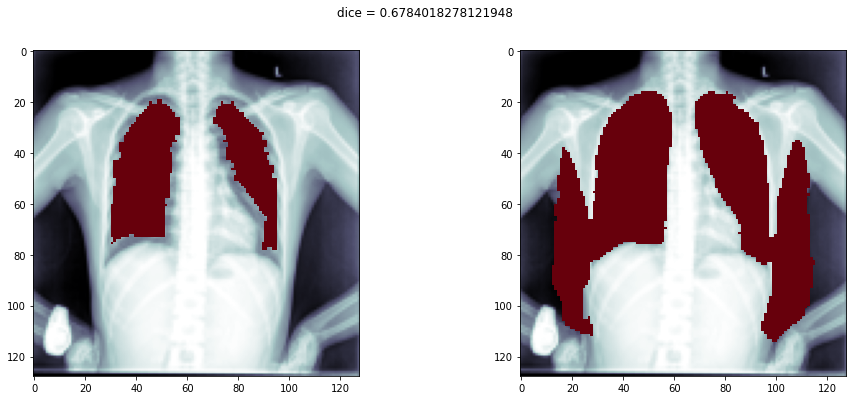

In [6]:
min_dsc = get_minvalue(dice)
plot_compare(min_dsc, metric="dice = {}".format(dice[min_dsc]))

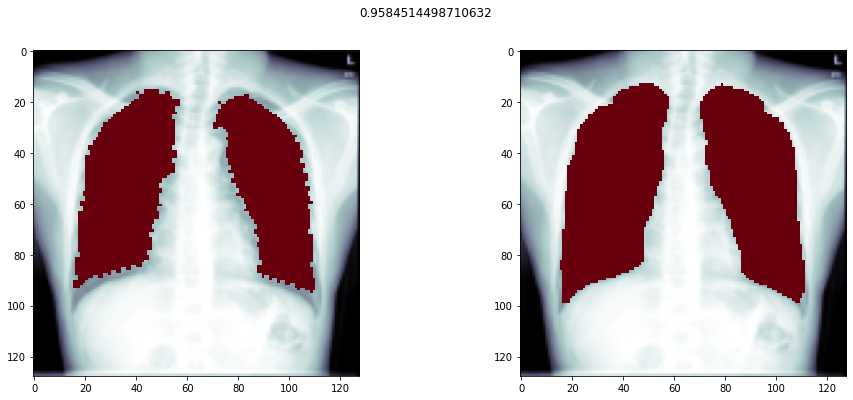

In [7]:
max_dsc = get_maxvalue(dice)
plot_compare(max_dsc, metric="{}".format(dice[max_dsc]))

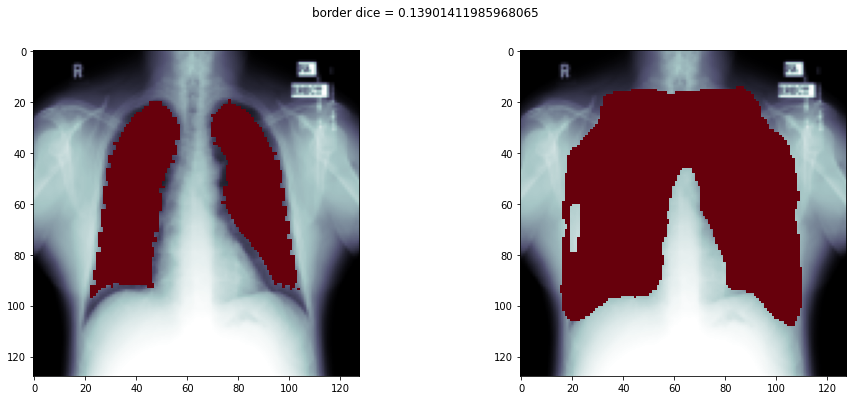

In [8]:
min_bdsc = get_minvalue(bdsc)
plot_compare(min_bdsc, metric="border dice = {}".format(bdsc[min_bdsc]))

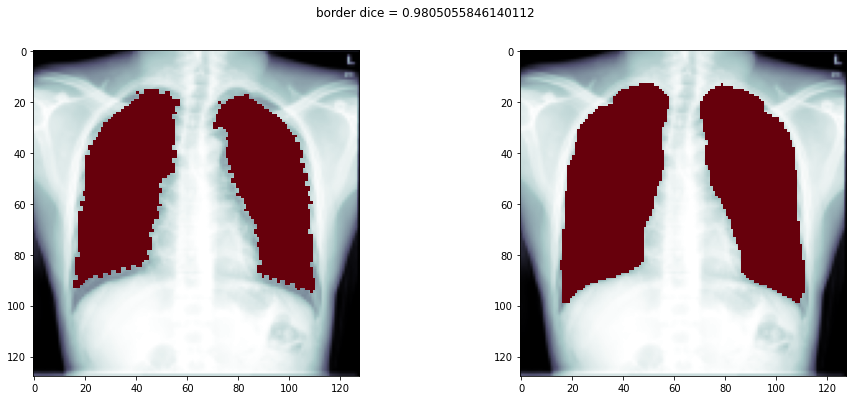

In [9]:
max_bdsc = get_maxvalue(bdsc)
plot_compare(max_bdsc, metric="border dice = {}".format(bdsc[max_bdsc]))